<a href="https://colab.research.google.com/github/OBulun/AN2DL_CH_2/blob/Negm-(Branched-Off-Olgun)/Notebooks/RetCCLResNet50_BEST_RESULT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1. Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
cur_dir = "/content/drive/MyDrive/AN2DL_CH_2/"
%cd $cur_dir


In [ ]:
#%pip install torchview
%pip install ray[tune] optuna

In [ ]:
LOCAL = False


## **2. Import Libraries**

In [ ]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'


# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph
from scipy import ndimage
from PIL import Image
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms as tfs


# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from tqdm import tqdm
import glob
from pathlib import Path
import shutil
import gc
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import torch.nn.functional as F

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.4.1+cu124
Device: cuda


## **3. Config**

In [ ]:
USE_MASKED_PATCHES = False

In [ ]:
datasets_path = os.path.join(os.path.pardir, "an2dl2526c2")

train_data_path = os.path.join(datasets_path, "train_data")
train_labels_path = os.path.join(datasets_path, "train_labels.csv")
test_data_path = os.path.join(datasets_path, "test_data")

CSV_PATH = train_labels_path                # Path to the CSV file with labels
SOURCE_FOLDER = train_data_path

if USE_MASKED_PATCHES:
  PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results_masked","train_patches_masked")
  SUBMISSION_PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results_masked","submission_patches_masked")
else:
  PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results","train_patches")
  SUBMISSION_PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results","submission_patches")

print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")
print(f"Patches output path: {PATCHES_OUT}")
print(f"Submission patches output path: {SUBMISSION_PATCHES_OUT}")




TARGET_SIZE = (224, 224)                    # Target size for the resized images and masks

Dataset path: ../an2dl2526c2
Train data path: ../an2dl2526c2/train_data
Train labels path: ../an2dl2526c2/train_labels.csv
Test data path: ../an2dl2526c2/test_data
Patches output path: ../an2dl2526c2/preprocessing_results/train_patches
Submission patches output path: ../an2dl2526c2/preprocessing_results/submission_patches


In [ ]:
# Create a simple function to handle this
def print_model_stats(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {trainable_params:,}")

In [ ]:
def get_image_predictions(model, loader, device):
    """
    Aggregates patch-level predictions to image-level.
    Strategy: Average the Softmax probabilities of all patches in a bag,
    then take the argmax. This handles 'noisy/benign' patches well.
    """
    model.eval()

    # Access the dataframe and transform stored in the dataset
    dataset = loader.dataset
    df = dataset.df
    transform = dataset.transform

    y_true = []
    y_pred = []

    # Get unique sample IDs (original images)
    sample_ids = df['sample_id'].unique()

    print(f"\nAggregating predictions for {len(sample_ids)} unique images...")

    for sample_id in tqdm(sample_ids, leave=False):
        # Get all patches belonging to this image
        sample_patches = df[df['sample_id'] == sample_id]

        # Ground Truth (all patches share the image label)
        true_label = sample_patches.iloc[0]['label_encoded']
        y_true.append(true_label)

        # Load and process all patches for this image
        patches = []
        for img_path in sample_patches['path']:
            try:
                # Load image (ensure RGB)
                img = Image.open(img_path).convert('RGB')
                if transform:
                    img = transform(img)
                patches.append(img)
            except Exception as e:
                continue

        if not patches:
            y_pred.append(true_label) # Fallback (should not happen)
            continue

        # Stack patches into a single batch: [Num_Patches, 3, 224, 224]
        batch = torch.stack(patches).to(device)

        with torch.no_grad():
            logits = model(batch)
            probs = torch.softmax(logits, dim=1)

            # --- Aggregation: Mean Probability ---
            # Averaging probabilities reduces the impact of outliers (benign patches)
            avg_probs = torch.mean(probs, dim=0)
            pred_label = torch.argmax(avg_probs).item()

        y_pred.append(pred_label)

    return y_true, y_pred


In [ ]:
def plot_sample_with_predictions(model, loader, device, label_encoder, sample_id=None, aggregation_method='max_confidence'):
    """Plot all patches of a single sample and the aggregated image prediction."""
    import math
    model.eval()
    dataset = loader.dataset
    df = dataset.df

    # Pick a sample_id
    if sample_id is None:
        sample_id = np.random.choice(df['sample_id'].unique())
    sample_patches = df[df['sample_id'] == sample_id].reset_index(drop=True)

    # Load and transform all patches
    images_tensors = []
    display_imgs = []
    for _, row in sample_patches.iterrows():
        img = Image.open(row['path']).convert('RGB')
        if dataset.transform:
            tensor_img = dataset.transform(img)
        else:
            tensor_img = transforms.ToTensor()(img)
        images_tensors.append(tensor_img)
        # denormalize for display
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        display_imgs.append(torch.clamp(tensor_img * std + mean, 0, 1))

    batch = torch.stack(images_tensors).to(device)
    with torch.no_grad():
        logits = model(batch)
        probs = torch.softmax(logits, dim=1).cpu()

    patch_preds = probs.argmax(dim=1).numpy()
    patch_confs = probs.max(dim=1).values.numpy()

    if aggregation_method == 'max_confidence':
        # Average probabilities (Soft Voting)
        image_probs = probs.mean(dim=0).numpy()
        image_pred = image_probs.argmax()
        image_conf = image_probs[image_pred]
    elif aggregation_method == 'majority_voting':
        # Hard Voting
        counts = np.bincount(patch_preds, minlength=len(label_encoder.classes_))
        image_pred = counts.argmax()
        # Normalize counts for visualization purposes
        image_probs = counts / counts.sum()
        image_conf = image_probs[image_pred]
    else:
        raise ValueError(f"Unknown aggregation method: {aggregation_method}")

    image_pred_label = label_encoder.inverse_transform([image_pred])[0]
    true_label = label_encoder.inverse_transform([sample_patches.iloc[0]['label_encoded']])[0]

    cols = min(6, len(sample_patches))
    rows = math.ceil(len(sample_patches) / cols)
    fig = plt.figure(figsize=(3*cols + 4, 3*rows))
    gs = fig.add_gridspec(rows, cols + 1, width_ratios=[1]*cols + [1.3])

    # Patch grid
    for idx, (img_disp, pred, conf) in enumerate(zip(display_imgs, patch_preds, patch_confs)):
        ax = fig.add_subplot(gs[idx // cols, idx % cols])
        ax.imshow(img_disp.permute(1,2,0))
        lbl = label_encoder.inverse_transform([pred])[0]
        ax.set_title(f"{lbl}\n{conf:.2%}", fontsize=9)
        ax.axis('off')

    # Aggregated distribution
    ax_bar = fig.add_subplot(gs[:, -1])
    class_names = label_encoder.classes_
    colors = ['green' if i == image_pred else 'steelblue' for i in range(len(class_names))]
    ax_bar.barh(class_names, image_probs, color=colors)
    ax_bar.set_xlabel('Probability' if aggregation_method == 'max_confidence' else 'Vote Share')
    ax_bar.set_xlim([0,1])
    ax_bar.set_title(f"Sample: {sample_id}\nTrue: {true_label} | Pred: {image_pred_label} ({image_conf:.2%})\nMethod: {aggregation_method}")
    for i, prob in enumerate(image_probs):
        ax_bar.text(prob + 0.02, i, f"{prob:.3f}", va='center')
    plt.tight_layout()
    plt.show()

## **4. Train/Val Split**

In [ ]:
def create_metadata_dataframe(patches_dir, labels_csv_path):
    """
    Creates a DataFrame mapping patch filenames to their Bag IDs and Labels.
    """
    # 1. Load the labels CSV
    # Assuming CSV structure: [image_id, label] or similar
    df_labels = pd.read_csv(labels_csv_path)

    # Standardize column names for easier merging
    # We assume the first column is the ID and the second is the Label
    id_col = df_labels.columns[0]
    label_col = df_labels.columns[1]

    # Ensure IDs in CSV are strings (to match filenames)
    df_labels[id_col] = df_labels[id_col].astype(str)

    # If the CSV IDs contain extensions (e.g., 'img_001.png'), remove them
    # because our parsed Bag IDs won't have them.
    df_labels[id_col] = df_labels[id_col].apply(lambda x: os.path.splitext(x)[0])

    # 2. List all patch files
    patch_files = [f for f in os.listdir(patches_dir) if f.endswith('.png')]

    # 3. Parse filenames to get Bag IDs
    data = []
    print(f"Found {len(patch_files)} patches. Parsing metadata...")

    for filename in patch_files:
        # Expected format from your preprocessing: {base_name}_p{i}.png
        # Example: "img_0015_p12.png" -> Bag ID should be "img_0015"

        # Split from the right on '_p' to separate Bag ID from Patch Index
        # "img_0015_p12.png" -> ["img_0015", "12.png"]
        try:
            bag_id = filename.rsplit('_p', 1)[0]

            data.append({
                'filename': filename,
                'sample_id': bag_id,
                'path': os.path.join(patches_dir, filename)
            })
        except IndexError:
            print(f"Skipping malformed filename: {filename}")

    # Create temporary patches DataFrame
    df_patches = pd.DataFrame(data)

    # 4. Merge patches with labels
    # This assigns the correct Bag Label to every Patch in that Bag
    df = pd.merge(df_patches, df_labels, left_on='sample_id', right_on=id_col, how='inner')

    # 5. Clean up and Rename
    # Keep only required columns
    df = df[['filename', label_col, 'sample_id', 'path']]

    # Rename label column to standard 'label' if it isn't already
    df = df.rename(columns={label_col: 'label'})

    print(f"Successfully created DataFrame with {len(df)} rows.")
    return df

In [ ]:
patches_metadata_df = create_metadata_dataframe(PATCHES_OUT, CSV_PATH)

# Verify the result
print("\nFirst 5 rows:")
print(patches_metadata_df.head().drop(columns=['path']))
print("\nPatches per Bag (Distribution):")
print(patches_metadata_df['sample_id'].value_counts().describe())

Found 3097 patches. Parsing metadata...
Successfully created DataFrame with 3097 rows.

First 5 rows:
          filename      label sample_id
0  img_0690_p2.png  Luminal A  img_0690
1  img_0690_p1.png  Luminal A  img_0690
2  img_0690_p0.png  Luminal A  img_0690
3  img_0689_p3.png  Luminal A  img_0689
4  img_0689_p2.png  Luminal A  img_0689

Patches per Bag (Distribution):
count    631.000000
mean       4.908082
std        2.913207
min        1.000000
25%        3.000000
50%        4.000000
75%        6.000000
max       23.000000
Name: count, dtype: float64


In [ ]:
# Add Label Encoding
print("\n" + "="*50)
print("Label Encoding")
print("="*50)

label_encoder = LabelEncoder()
patches_metadata_df['label_encoded'] = label_encoder.fit_transform(patches_metadata_df['label'])

print(f"\nOriginal Labels: {label_encoder.classes_}")
print(f"Encoded as: {list(range(len(label_encoder.classes_)))}")
print(f"\nLabel Mapping:")
for orig, enc in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"  {orig} -> {enc}")


Label Encoding

Original Labels: ['HER2(+)' 'Luminal A' 'Luminal B' 'Triple negative']
Encoded as: [0, 1, 2, 3]

Label Mapping:
  HER2(+) -> 0
  Luminal A -> 1
  Luminal B -> 2
  Triple negative -> 3


In [ ]:
# Train/Val Split on Original Images (not patches)
print("\n" + "="*50)
print("Train/Val Split on Original Images")
print("="*50)

# Get unique sample IDs
unique_samples = patches_metadata_df['sample_id'].unique()
print(f"\nTotal unique samples (original images): {len(unique_samples)}")

# Split samples into train (80%) and val (20%)
train_samples, val_samples = train_test_split(
    unique_samples,
    test_size=0.2,
    random_state=SEED,
    stratify=patches_metadata_df.drop_duplicates('sample_id').set_index('sample_id').loc[unique_samples, 'label_encoded'].values
)

print(f"Train samples: {len(train_samples)}")
print(f"Val samples: {len(val_samples)}")

# Create train and val DataFrames by filtering patches
df_train = patches_metadata_df[patches_metadata_df['sample_id'].isin(train_samples)].reset_index(drop=True)
df_val = patches_metadata_df[patches_metadata_df['sample_id'].isin(val_samples)].reset_index(drop=True)

print(f"\nTrain patches: {len(df_train)}")
print(f"Val patches: {len(df_val)}")
print(f"\nTrain label distribution:\n{df_train['label'].value_counts()}")
print(f"\nVal label distribution:\n{df_val['label'].value_counts()}")

# Print percentage distribution
print(f"\n" + "="*50)
print("Percentage Distribution")
print("="*50)
print(f"\nTrain label percentage:\n{df_train['label'].value_counts(normalize=True) * 100}")
print(f"\nVal label percentage:\n{df_val['label'].value_counts(normalize=True) * 100}")


Train/Val Split on Original Images

Total unique samples (original images): 631
Train samples: 504
Val samples: 127

Train patches: 2445
Val patches: 652

Train label distribution:
label
Luminal B          852
Luminal A          684
HER2(+)            676
Triple negative    233
Name: count, dtype: int64

Val label distribution:
label
Luminal B          238
HER2(+)            160
Luminal A          159
Triple negative     95
Name: count, dtype: int64

Percentage Distribution

Train label percentage:
label
Luminal B          34.846626
Luminal A          27.975460
HER2(+)            27.648262
Triple negative     9.529652
Name: proportion, dtype: float64

Val label percentage:
label
Luminal B          36.503067
HER2(+)            24.539877
Luminal A          24.386503
Triple negative    14.570552
Name: proportion, dtype: float64


## **5. Transformations & Augmentation**

In [ ]:
# Define augmentation for training with enhanced transformations
train_augmentation = transforms.Compose([
    # Geometric transformations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),  # Small rotations to handle orientation variations
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),  # Reduced from 0.2 for more conservative shifts
        scale=None,  # Add scale variation
        shear=10  # Add shear transformation
    ),

    # Color/appearance transformations
    transforms.ColorJitter(
        brightness=0.2,  # Adjust brightness
        contrast=0.2,    # Adjust contrast
        saturation=0.2,  # Adjust saturation
        hue=0.1          # Slight hue variation
    ),
    #transforms.RandomGrayscale(p=0.1),  # Occasionally convert to grayscale to improve robustness

    # Occlusion simulation
    #transforms.RandomErasing(
    #    p=0.3,  # Reduced probability for more balanced augmentation
    #    scale=(0.02, 0.15),  # Reduced max scale
    #    ratio=(0.3, 3.3)  # Aspect ratio range
    #),

    # Optional: Add Gaussian blur for noise robustness
    # transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
])

## **6. Custom Dataset Class**

In [ ]:
# ImageNet normalization statistics
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

class TissueDataset(torch.utils.data.Dataset):
    def __init__(self, df, augmentation=None, normalize_imagenet=False, cache_images=True):
        self.augmentation = augmentation
        self.normalize_imagenet = normalize_imagenet
        self.df = df

        # CRITICAL OPTIMIZATION: Pre-convert to lists
        self.paths = df['path'].tolist()
        self.labels = df['label_encoded'].tolist()

        # Define transforms
        self.to_tensor = transforms.Compose([
            transforms.Resize(TARGET_SIZE),
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True)
        ])

        if normalize_imagenet:
            self.normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
        else:
            self.normalize = None

        # For external use
        self.transform = transforms.Compose([
            transforms.Resize(TARGET_SIZE),
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True),
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) if normalize_imagenet else transforms.Identity()
        ])

        # --- IMAGE CACHING (Pre-load all images) ---
        self.image_cache = {}
        if cache_images:
            self._preload_images()

    def _preload_images(self):
        """Pre-load all images into memory for O(1) access during training."""
        total_images = len(self.paths)

        with tqdm(total=total_images, desc="Pre-loading images", unit="img") as pbar:
            for img_path in self.paths:
                if img_path not in self.image_cache:
                    try:
                        image = Image.open(img_path).convert("RGB")
                        image = self.to_tensor(image)
                        self.image_cache[img_path] = image
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
                        self.image_cache[img_path] = None

                pbar.update(1)

        print(f"Successfully cached {len(self.image_cache)} images.")

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = self.labels[idx]

        # Load image (from cache or disk)
        if img_path in self.image_cache:
            image = self.image_cache[img_path]
            if image is None:
                # Fallback for corrupted cached images
                image = torch.ones((3, TARGET_SIZE[0], TARGET_SIZE[1]), dtype=torch.float32) * 0.5
        else:
            # Fallback: Load on-the-fly if not cached
            try:
                img = Image.open(img_path).convert('RGB')
                image = self.to_tensor(img)
            except:
                image = torch.ones((3, TARGET_SIZE[0], TARGET_SIZE[1]), dtype=torch.float32) * 0.5

        # Apply augmentation
        if self.augmentation:
            image = self.augmentation(image)

        # Apply normalization
        if self.normalize:
            image = self.normalize(image)

        return image, label

## **7. Data Loaders**

In [ ]:
if LOCAL:
    num_workers = 0
    CACHE_IMAGES = False
else:
    num_workers = os.cpu_count()//2
    CACHE_IMAGES = True

# Instantiate Datasets
train_dataset = TissueDataset(
    df_train,
    augmentation=train_augmentation,
    normalize_imagenet=True,
    cache_images=CACHE_IMAGES  # Enable image pre-loading
)
val_dataset = TissueDataset(
    df_val,
    augmentation=None,
    normalize_imagenet=True,
    cache_images=CACHE_IMAGES  # Enable image pre-loading
)

In [ ]:
def get_data_loaders(batch_size):
    # CHANGE: Set cache_images=True because you have Colab Pro RAM
    train_ds = TissueDataset(df_train, augmentation=train_augmentation,
                             normalize_imagenet=True, cache_images=True)

    val_ds = TissueDataset(df_val, augmentation=None,
                           normalize_imagenet=True, cache_images=True)

    # CHANGE: Increase num_workers to 4 (Colab Pro usually gives 4+ cores)
    t_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          num_workers=4, pin_memory=True)
    v_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                          num_workers=4, pin_memory=True)

    return t_loader, v_loader

In [ ]:
def train_retccl_ray(config):
    # 1. Setup Device & Loaders
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, val_loader = get_data_loaders(config['batch_size'])

    # 2. Initialize Model with Config Params
    # We pass the 'dropout_rate' chosen by Ray
    model = RetCCLResNet50(
        num_classes=len(label_encoder.classes_),
        dropout_rate=config['dropout_rate'],
        freeze_backbone=True,
        ckpt_path=os.path.join("models", "best_ckpt.pth"), # Ensure this path is correct!
        unfreeze_last_block=False # We will handle unfreezing manually below
    )
    model = model.to(device)

    # 3. Dynamic Unfreezing Strategy
    # Ray decides how many layers to unfreeze (0 means only head, 4 means lots of backbone)
    if config['unfreeze_depth'] > 0:
        # Get all child modules of the backbone
        # For ResNet, children are: [conv1, bn1, ..., layer1, layer2, layer3, layer4]
        backbone_layers = list(model.backbone.children())

        # Unfreeze the last N layers
        layers_to_unfreeze = backbone_layers[-config['unfreeze_depth']:]
        for layer in layers_to_unfreeze:
            for param in layer.parameters():
                param.requires_grad = True

    # 4. Optimizer & Loss
    # We use the Learning Rate and Weight Decay chosen by Ray
    optimizer = torch.optim.RAdam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=config['lr'],
        weight_decay=config['weight_decay']
    )

    criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])

    # 5. Training Loop (Standard Epochs)
    # We define a "max" of 15 epochs per trial. Ray will cut bad ones short.
    for epoch in range(15):
        train_loss, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_f1 = validate(model, val_loader, criterion, device)

        # CRITICAL: Send metrics back to Ray
        tune.report({"f1": val_f1, "loss": val_loss})

In [ ]:


# Batch Size: 32 or 64 is standard for ResNet18/50 on 1MP images
BATCH_SIZE = 64



# Instantiate Loaders with optimizations
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
 # Keep workers alive between epochs
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
# Keep workers alive between epochs
)

print(f"Train Loader: {len(train_loader)} batches")
print(f"Val Loader: {len(val_loader)} batches")
print(f"Num workers: {train_loader.num_workers}")

Train Loader: 39 batches
Val Loader: 11 batches
Num workers: 24



Visualizing Training Batch (Augmented):


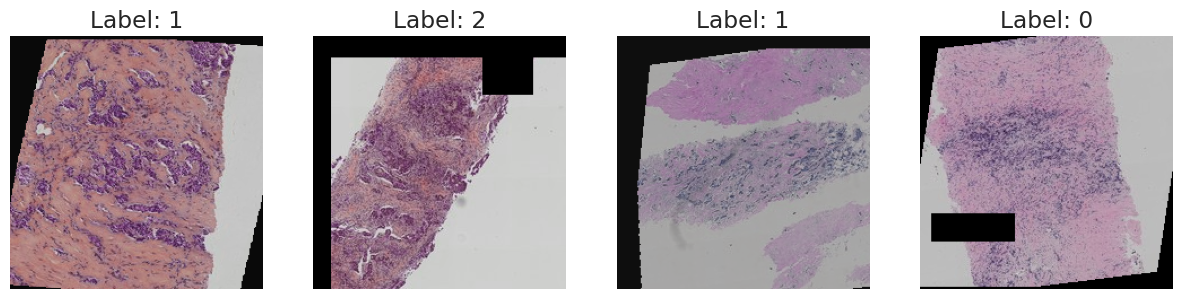

In [ ]:
def show_batch(loader, count=4):
    images, labels = next(iter(loader))
    plt.figure(figsize=(15, 5))

    # Denormalize for visualization
    mean = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
    std = torch.tensor(IMAGENET_STD).view(3, 1, 1)

    for i in range(count):
        ax = plt.subplot(1, count, i + 1)

        img = images[i]
        img = img * std + mean  # Un-normalize

        img = torch.clamp(img, 0, 1)  # Clip to valid range

        plt.imshow(img.permute(1, 2, 0)) # CHW -> HWC
        plt.title(f"Label: {labels[i].item()}")
        plt.axis("off")
    plt.show()

print("\nVisualizing Training Batch (Augmented):")
show_batch(train_loader)

## **8. Hyperparameters**

In [ ]:
search_space = {
    # Optimizer Tuning
    "lr": tune.loguniform(1e-5, 5e-4),           # Search between 0.00001 and 0.0005
    "weight_decay": tune.loguniform(1e-5, 1e-2), # Regularization strength

    # Architecture Tuning
    "dropout_rate": tune.uniform(0.1, 0.6),      # How much dropout in the head
    "label_smoothing": tune.uniform(0.0, 0.15),  # Helps with noisy histology labels

    # Strategy Tuning (The "Secret Sauce")
    # 0 = Just the head
    # 1-3 = Unfreeze parts of layer4
    # 4 = Unfreeze all of layer4
    "unfreeze_depth": tune.choice([1, 2, 3, 4]),

    "batch_size": tune.choice([32, 64])
}

In [ ]:
# Initialize the algorithm
optuna_search = OptunaSearch()

# Initialize the scheduler (Early Stopping)
asha_scheduler = ASHAScheduler(
    metric="f1",
    mode="max",
    max_t=15,             # Max epochs per trial
    grace_period=3,       # Don't stop anything before epoch 3
    reduction_factor=2    # Cut the bottom 50% of trials
)

print("Starting Ray Tune...")

analysis = tune.Tuner(
    tune.with_resources(train_retccl_ray, resources={"cpu": 4, "gpu": 0.5}),
    param_space=search_space,
    tune_config=tune.TuneConfig(
        search_alg=optuna_search,
        scheduler=asha_scheduler,
        num_samples=50,  # Run 20 different experiments. Increase if you have time.
    )
).fit()

best_result = analysis.get_best_result(metric="f1", mode="max")
print("Best config found:", best_result.config)
print("Best Validation F1:", best_result.metrics['f1'])

## **9. Model Definition (Transfer Learning - MobileNetV3)**

In [ ]:
import torch
import torch.nn as nn

# IMPORTANT: this is RetCCL's ResNet implementation (copy ResNet.py from the RetCCL repo)
import ResNet as RetCCLResNet


def _clean_state_dict(sd: dict) -> dict:
    """Strip common prefixes (DataParallel, wrapper modules)."""
    out = {}
    for k, v in sd.items():
        for p in ("module.", "model.", "encoder.", "backbone."):
            if k.startswith(p):
                k = k[len(p):]
        out[k] = v
    return out


class RetCCLResNet50(nn.Module):
    """
    Drop-in replacement for your ResNet18 class, but using RetCCL (CNN) ResNet50 backbone.

    Args match your original:
      - num_classes
      - dropout_rate
      - freeze_backbone

    Extra:
      - ckpt_path: path to RetCCL checkpoint (e.g., best_ckpt.pth)
      - unfreeze_last_block: often helps on small datasets
    """
    def __init__(
        self,
        num_classes: int,
        dropout_rate: float = 0.2,
        freeze_backbone: bool = True,
        ckpt_path: str = "best_ckpt.pth",
        unfreeze_last_block: bool = True,
    ):
        super().__init__()

        # 1) Build RetCCL ResNet50 (their script uses num_classes=128 for the pretext head)
        self.backbone = RetCCLResNet.resnet50(
            num_classes=128, mlp=False, two_branch=False, normlinear=True
        )

        # 2) Load RetCCL pretrained weights
        sd = torch.load(ckpt_path, map_location="cpu")
        if isinstance(sd, dict) and "state_dict" in sd:
            sd = sd["state_dict"]
        sd = _clean_state_dict(sd)

        # Drop any fc keys from the checkpoint (we replace the head anyway)
        sd = {k: v for k, v in sd.items() if not k.startswith("fc.")}

        msg = self.backbone.load_state_dict(sd, strict=False)
        # Uncomment for debugging:
        # print("Missing keys:", msg.missing_keys)
        # print("Unexpected keys:", msg.unexpected_keys)

        # 3) Replace fc with your custom multi-layer head
        # RetCCL fc may not expose .in_features (e.g., NormLinear), so use weight shape
        if hasattr(self.backbone.fc, "in_features"):
            in_features = self.backbone.fc.in_features
        elif hasattr(self.backbone.fc, "weight"):
            in_features = self.backbone.fc.weight.shape[1]
        else:
            # ResNet50 default is 2048 if all else fails
            in_features = 2048

        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 1024),
            nn.Hardswish(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, num_classes),
        )

        # 4) Freeze backbone (optional) + optionally unfreeze last block
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False

            # always train the new head
            for p in self.backbone.fc.parameters():
                p.requires_grad = True

            # often beneficial for small pathology datasets
            if unfreeze_last_block and hasattr(self.backbone, "layer4"):
                for p in self.backbone.layer4.parameters():
                    p.requires_grad = True

    def forward(self, x):
        return self.backbone(x)


In [ ]:
# Initialize the model
# Ensure device is defined (usually from previous cells, but safe to redefine if standalone)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming label_encoder is defined in your notebook scope
num_classes = len(label_encoder.classes_)
model = RetCCLResNet50(num_classes, DROPOUT_RATE,
                       freeze_backbone=True  ,
                       ckpt_path=os.path.join("models","best_ckpt.pth"),
                       unfreeze_last_block=False)
model = model.to(device)

print(f"Model initialized (RetCCLResNet50) with {num_classes} output classes.")
summary(model, input_size=(3, TARGET_SIZE[0], TARGET_SIZE[1]))

Model initialized (RetCCLResNet50) with 4 output classes.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 5

## **11. Function: Training & Validation Loop**

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    # Lists to store all predictions and labels for F1 calculation
    all_preds = []
    all_labels = []

    loop = tqdm(loader, leave=False)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics accumulation
        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)

        # Move to CPU and convert to numpy for sklearn metrics
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        loop.set_description(f"Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(loader.dataset)
    # Calculate F1 Score (Macro for imbalanced data)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')

    return epoch_loss, epoch_f1

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')

    return epoch_loss, epoch_f1

In [ ]:
# --- CELL A: Data Loader Wrapper ---
def get_data_loaders(batch_size):
    # COLAB PRO OPTIMIZATION: cache_images=True
    # We load the full dataset into High-RAM for massive speed speedups
    train_ds = TissueDataset(df_train, augmentation=train_augmentation,
                             normalize_imagenet=True, cache_images=True)

    val_ds = TissueDataset(df_val, augmentation=None,
                           normalize_imagenet=True, cache_images=True)

    # COLAB PRO OPTIMIZATION: num_workers=4
    # Utilization of extra CPU cores provided by Pro
    t_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          num_workers=4, pin_memory=True)
    v_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                          num_workers=4, pin_memory=True)

    return t_loader, v_loader

In [ ]:
# --- CELL B: Ray Trainable Function ---
def train_retccl_ray(config):
    # 1. Setup Device & Loaders
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, val_loader = get_data_loaders(config['batch_size'])

    # 2. Initialize Model with Config Params
    # We assume 'label_encoder' exists from Section 3/4
    model = RetCCLResNet50(
        num_classes=len(label_encoder.classes_),
        dropout_rate=config['dropout_rate'],
        freeze_backbone=True,
        ckpt_path=os.path.join("models", "best_ckpt.pth"), # Ensure this path exists!
        unfreeze_last_block=False
    )
    model = model.to(device)

    # 3. Dynamic Unfreezing Strategy (The Secret Sauce)
    if config['unfreeze_depth'] > 0:
        # Get all child modules of the backbone
        backbone_layers = list(model.backbone.children())
        # Unfreeze the last N layers
        layers_to_unfreeze = backbone_layers[-config['unfreeze_depth']:]
        for layer in layers_to_unfreeze:
            for param in layer.parameters():
                param.requires_grad = True

    # 4. Optimizer & Loss
    optimizer = torch.optim.RAdam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=config['lr'],
        weight_decay=config['weight_decay']
    )

    criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])

    # 5. Training Loop (Max 15 epochs per trial)
    # ASHA will cut bad trials off much earlier (e.g., epoch 3)
    for epoch in range(15):
        train_loss, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_f1 = validate(model, val_loader, criterion, device)

        # Report metrics to Ray
        tune.report({"f1": val_f1, "loss": val_loss})

In [ ]:
# --- CELL C: Execution ---
search_space = {
    "lr": tune.loguniform(1e-5, 5e-4),
    "weight_decay": tune.loguniform(1e-5, 1e-2),
    "dropout_rate": tune.uniform(0.2, 0.5),
    "label_smoothing": tune.uniform(0.0, 0.15),
    "unfreeze_depth": tune.choice([1, 2, 3, 4]), # 1=Light tuning, 4=Deep tuning
    "batch_size": tune.choice([32, 64])
}

optuna_search = OptunaSearch()

asha_scheduler = ASHAScheduler(
    metric="f1", mode="max",
    max_t=15, grace_period=3, reduction_factor=2
)

print("Starting Ray Tune on Colab Pro...")

analysis = tune.Tuner(
    # COLAB PRO: cpu=4 to match workers. gpu=1 (or 0.5 if you have A100)
    tune.with_resources(train_retccl_ray, resources={"cpu": 4, "gpu": 1}),
    param_space=search_space,
    tune_config=tune.TuneConfig(
        search_alg=optuna_search,
        scheduler=asha_scheduler,
        num_samples=50,  # 50 Samples for high accuracy
    )
).fit()

best_result = analysis.get_best_result(metric="f1", mode="max")
print("Best config found:", best_result.config)

In [ ]:
# --- CELL D: Retrain Winner ---
best_config = best_result.config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Retraining final model with best params...")

# 1. Build Final Model
final_model = RetCCLResNet50(
    num_classes=len(label_encoder.classes_),
    dropout_rate=best_config['dropout_rate'],
    freeze_backbone=True,
    ckpt_path=os.path.join("models", "best_ckpt.pth"),
    unfreeze_last_block=False
)
final_model = final_model.to(device)

# 2. Unfreeze
if best_config['unfreeze_depth'] > 0:
    backbone_layers = list(final_model.backbone.children())
    for layer in backbone_layers[-best_config['unfreeze_depth']:]:
        for param in layer.parameters():
            param.requires_grad = True

# 3. Optimizer
optimizer = torch.optim.RAdam(
    filter(lambda p: p.requires_grad, final_model.parameters()),
    lr=best_config['lr'],
    weight_decay=best_config['weight_decay']
)
criterion = nn.CrossEntropyLoss(label_smoothing=best_config['label_smoothing'])
# We add a scheduler here for the long run
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# 4. Long Training (25 Epochs)
# Use the global loaders from Section 7 (or recreate them if you prefer)
train_loader_final, val_loader_final = get_data_loaders(best_config['batch_size'])

best_val_f1 = 0.0
save_path = 'models/best_model_optimized.pt'

for epoch in range(25):
    train_loss, train_f1 = train_one_epoch(final_model, train_loader_final, criterion, optimizer, device)
    val_loss, val_f1 = validate(final_model, val_loader_final, criterion, device)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1} | Val F1: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(final_model.state_dict(), save_path)
        print(f" >>> Saved Best Model to {save_path}")

print("DONE.")

## **14. Class Activation Maps**

### **14.1 Cam Helper Functions**

In [ ]:
# --- 1. Grad-CAM Helper Class ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hooks
        # We hook into the target layer to intercept forward and backward passes
        self.handle_fwd = self.target_layer.register_forward_hook(self.save_activation)
        self.handle_bwd = self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        # Tuple of gradients; we want the first one corresponding to the output
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        # Forward pass
        output = self.model(x)
        if class_idx is None:
            class_idx = torch.argmax(output)

        # Backward pass
        self.model.zero_grad()
        score = output[0, class_idx]
        score.backward()

        # Generate CAM
        gradients = self.gradients
        activations = self.activations

        # b=batch, k=channels, u=height, v=width
        b, k, u, v = gradients.size()

        # Global Average Pooling of gradients
        alpha = gradients.view(b, k, -1).mean(2)
        weights = alpha.view(b, k, 1, 1)

        # Linear combination of activations weighted by alpha
        cam = (weights * activations).sum(1, keepdim=True)
        cam = F.relu(cam) # Apply ReLU to focus on positive contributions

        # Normalize
        cam = cam.view(1, -1)
        cam -= cam.min()
        cam /= (cam.max() + 1e-7)
        cam = cam.view(1, 1, u, v)

        return cam.detach().cpu().numpy()[0, 0], output

    def remove_hooks(self):
        self.handle_fwd.remove()
        self.handle_bwd.remove()

# --- 2. Mask Overlay Function ---
def get_mask_overlay(cam_mask, patch_path, masks_dir, img_fallback=None, alpha=0.6):
    """
    Overlays a Class Activation Map (CAM) onto the ground truth mask.
    Returns: (overlay_image, mask_found_boolean)
    """
    bg_img = None
    mask_found = False

    if masks_dir:
        # Derive mask filename: img_xxxx.png -> mask_xxxx.png
        filename = os.path.basename(patch_path)
        mask_filename = filename.replace('img_', 'mask_')
        mask_path = os.path.join(masks_dir, mask_filename)

        if os.path.exists(mask_path):
            try:
                mask_pil = Image.open(mask_path).convert('L')
                mask_pil = mask_pil.resize((224, 224))
                mask_np = np.array(mask_pil)
                # Normalize and convert to RGB
                mask_display = mask_np.astype(np.float32) / 255.0
                bg_img = np.stack([mask_display]*3, axis=-1)
                mask_found = True
            except Exception as e:
                print(f"Error loading mask {mask_filename}: {e}")

    # Fallback Logic
    if bg_img is None:
        if img_fallback is not None:
            bg_img = img_fallback
        else:
            bg_img = np.zeros((224, 224, 3), dtype=np.float32)

    # Process Heatmap
    heatmap = cv2.resize(cam_mask, (224, 224))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    heatmap_colored = np.float32(heatmap_colored) / 255

    # Overlay
    overlay = (alpha * heatmap_colored) + ((1 - alpha) * bg_img)
    overlay = overlay / np.max(overlay)

    return overlay, mask_found

# --- 3. Main Visualization Function ---
def visualize_sample_analysis(model, df_metadata, sample_id, label_encoder, device, masks_dir=None):
    """
    Visualizes analysis for a sample.
    Row 1: [Original], [CAM on Img], [CAM on Mask (HIDDEN if missing)], [Stats]
    Row 2: Other Classes CAMs (Fallback to Image if Mask missing)
    """
    model.eval()

    # Setup
    sample_rows = df_metadata[df_metadata['sample_id'] == sample_id]
    if len(sample_rows) == 0:
        print(f"Sample {sample_id} not found.")
        return

    transform_pipeline = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    inv_normalize = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                             std=[1/0.229, 1/0.224, 1/0.225])
    ])

    # Inference
    patch_probs = []
    patch_images = []

    # --- CRITICAL UPDATE FOR RESNET18 ---
    # ResNet structure: model.backbone.layer4 is the last block of layers
    # We select the last basic block [-1] from layer4
    target_layer = model.backbone.layer4[-1]

    grad_cam = GradCAM(model, target_layer)

    print(f"Processing sample {sample_id}...")

    for _, row in sample_rows.iterrows():
        img_pil = Image.open(row['path']).convert('RGB')
        img_tensor = transform_pipeline(img_pil).unsqueeze(0).to(device)
        patch_images.append({'tensor': img_tensor, 'path': row['path']})

        with torch.no_grad():
            outputs = model(img_tensor)
            probs = F.softmax(outputs, dim=1)
            patch_probs.append(probs.cpu().numpy())

    patch_probs = np.vstack(patch_probs)
    avg_probs = np.mean(patch_probs, axis=0)

    classes = label_encoder.classes_
    pred_class_idx = np.argmax(avg_probs)
    pred_label = classes[pred_class_idx]
    true_label = sample_rows.iloc[0]['label']

    # Best patch
    best_patch_idx = np.argmax(patch_probs[:, pred_class_idx])
    best_patch_data = patch_images[best_patch_idx]
    img_tensor_active = best_patch_data['tensor'].clone().detach().requires_grad_(True)
    patch_path = best_patch_data['path']

    # 1. Background Image
    img_display = inv_normalize(best_patch_data['tensor'][0]).cpu().detach().numpy()
    img_display = np.transpose(img_display, (1, 2, 0))
    img_display = np.clip(img_display, 0, 1)

    # 2. Predicted Class CAMs
    pred_cam_mask, _ = grad_cam(img_tensor_active, pred_class_idx)

    # A: Overlay on Image
    heatmap = cv2.resize(pred_cam_mask, (224, 224))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    heatmap_colored = np.float32(heatmap_colored) / 255
    cam_on_image = (0.5 * heatmap_colored) + (0.5 * img_display)
    cam_on_image = cam_on_image / np.max(cam_on_image)

    # B: Overlay on Mask (Row 1, Col 3)
    cam_on_mask_main, mask_found_main = get_mask_overlay(
        pred_cam_mask, patch_path, masks_dir, img_fallback=img_display
    )

    # 3. Other Classes CAMs (Row 2)
    cam_others_data = {}
    for i in range(len(classes)):
        if i == pred_class_idx: continue
        mask, _ = grad_cam(img_tensor_active, i)

        # We allow fallback here so we can still see activations for other classes
        overlay, is_mask = get_mask_overlay(
            mask, patch_path, masks_dir, img_fallback=img_display
        )
        cam_others_data[i] = (overlay, is_mask)

    grad_cam.remove_hooks()

    # --- Plotting ---
    other_indices = [i for i in range(len(classes)) if i != pred_class_idx]

    fig = plt.figure(figsize=(24, 10))
    gs = gridspec.GridSpec(2, max(4, len(other_indices)), height_ratios=[1.2, 0.8])

    # Row 1
    # 1. Original
    ax0 = plt.subplot(gs[0, 0])
    ax0.imshow(img_display)
    ax0.set_title(f"Most Representative Patch\nTrue: {true_label}", fontsize=12, fontweight='bold')
    ax0.axis('off')

    # 2. Predicted CAM on Image
    ax1 = plt.subplot(gs[0, 1])
    ax1.imshow(cam_on_image)
    ax1.set_title(f"Focus on Image: {pred_label}\n(Score: {avg_probs[pred_class_idx]:.2f})", fontsize=12, fontweight='bold', color='darkblue')
    ax1.axis('off')

    # 3. Predicted CAM on Mask (Conditional)
    ax2 = plt.subplot(gs[0, 2])
    if mask_found_main:
        ax2.imshow(cam_on_mask_main)
        ax2.set_title(f"Focus on Mask: {pred_label}\n(Ground Truth Overlay)", fontsize=12, fontweight='bold')
        ax2.axis('off')
    else:
        # Deactivate subplot if mask is missing (avoid redundancy with ax1)
        ax2.set_visible(False)

    # 4. Stats
    ax3 = plt.subplot(gs[0, 3])
    colors = ['#d3d3d3'] * len(classes)
    colors[pred_class_idx] = '#4CAF50' if pred_label == true_label else '#F44336'

    bars = ax3.bar(classes, avg_probs, color=colors, alpha=0.85, edgecolor='black')
    ax3.set_title(f"Bag Prediction Probabilities\nSample ID: {sample_id}", fontsize=12, fontweight='bold')
    ax3.set_ylim(0, 1.05)
    ax3.grid(axis='y', linestyle='--', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{height:.1%}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Row 2: Other Classes on MASK (with fallback)
    for idx, class_idx in enumerate(other_indices):
        ax = plt.subplot(gs[1, idx])
        overlay, is_mask = cam_others_data[class_idx]

        ax.imshow(overlay)
        class_name = classes[class_idx]
        bg_type = "Mask" if is_mask else "Img"
        ax.set_title(f"Activ. on {bg_type}: {class_name}\n(Score: {avg_probs[class_idx]:.2f})", fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

### **14.2 CAM Visualization**

Processing sample img_0601...


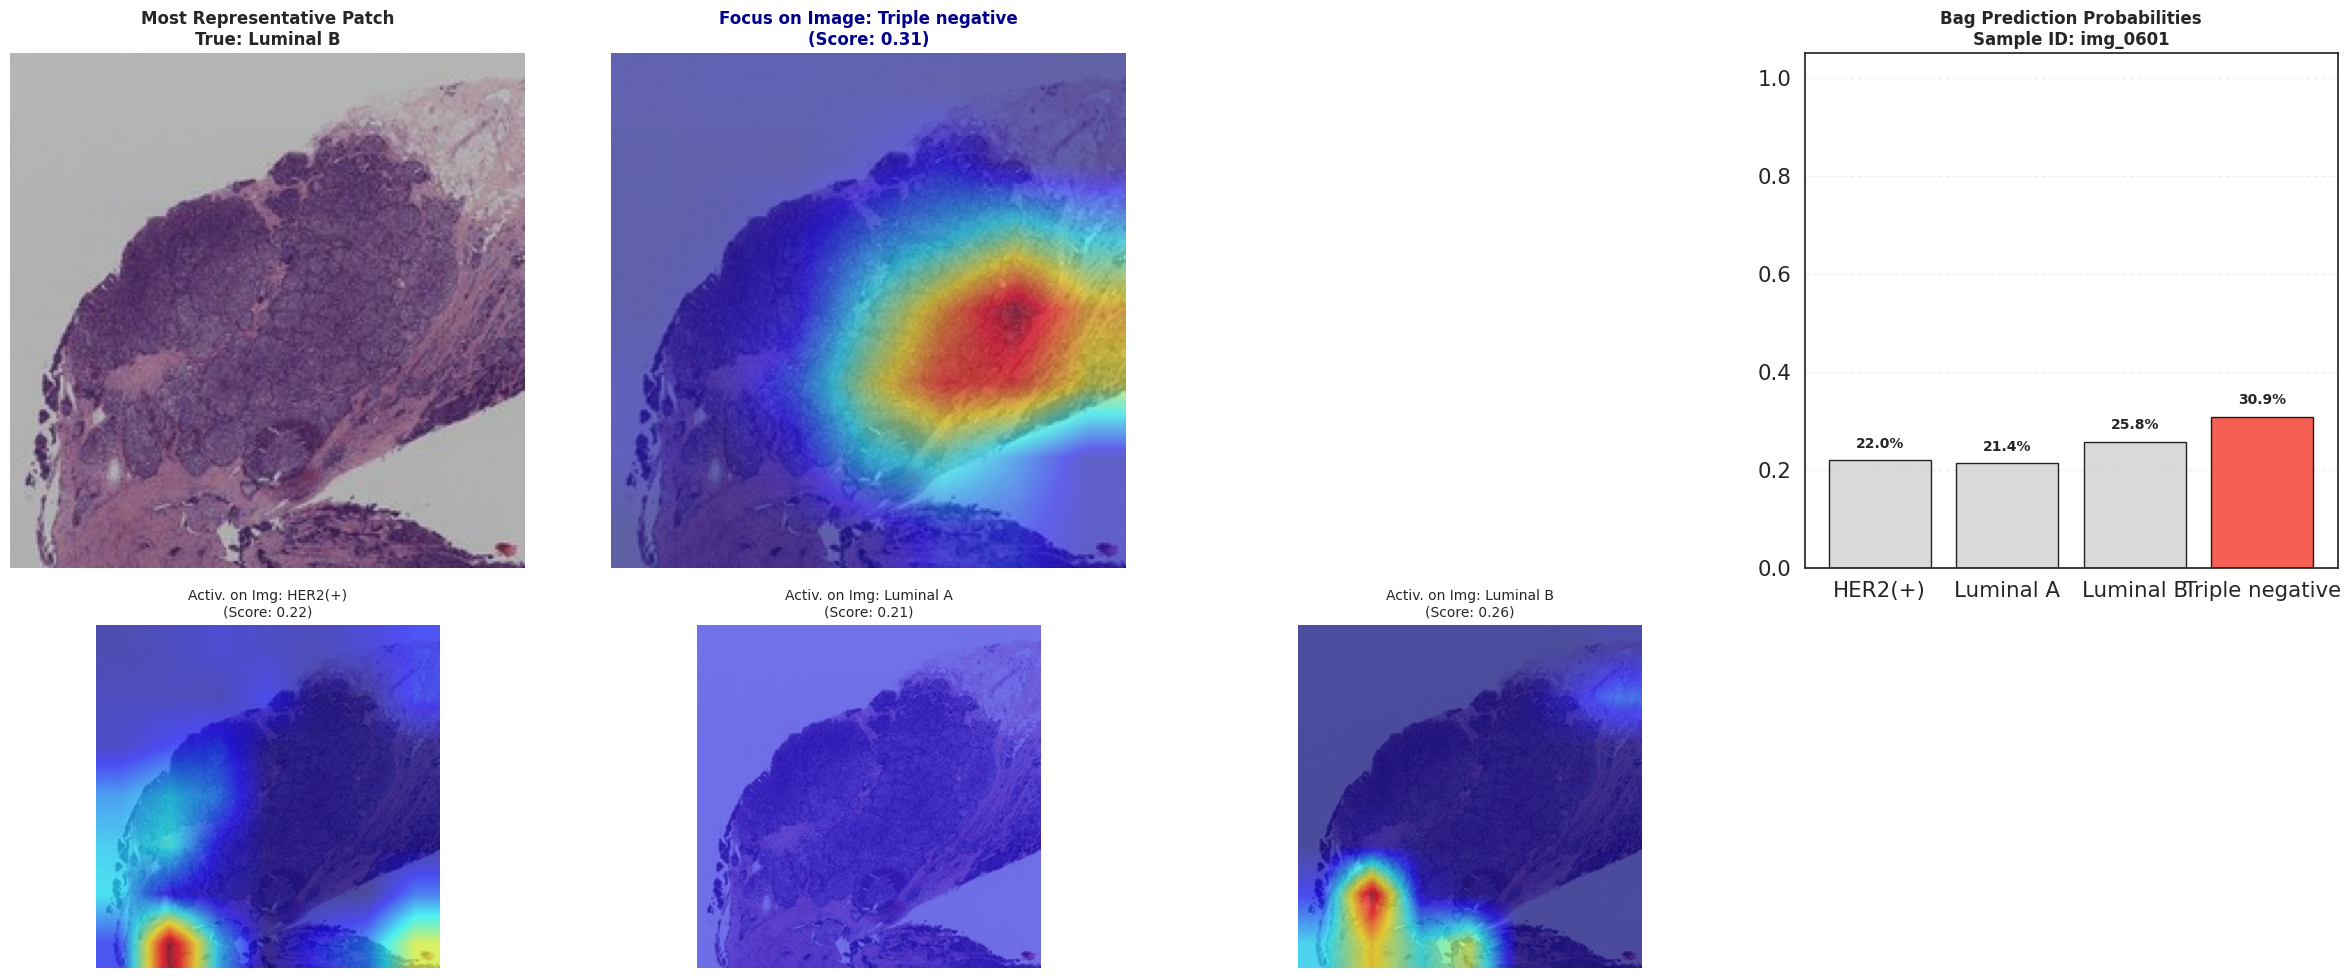

Processing sample img_0601...


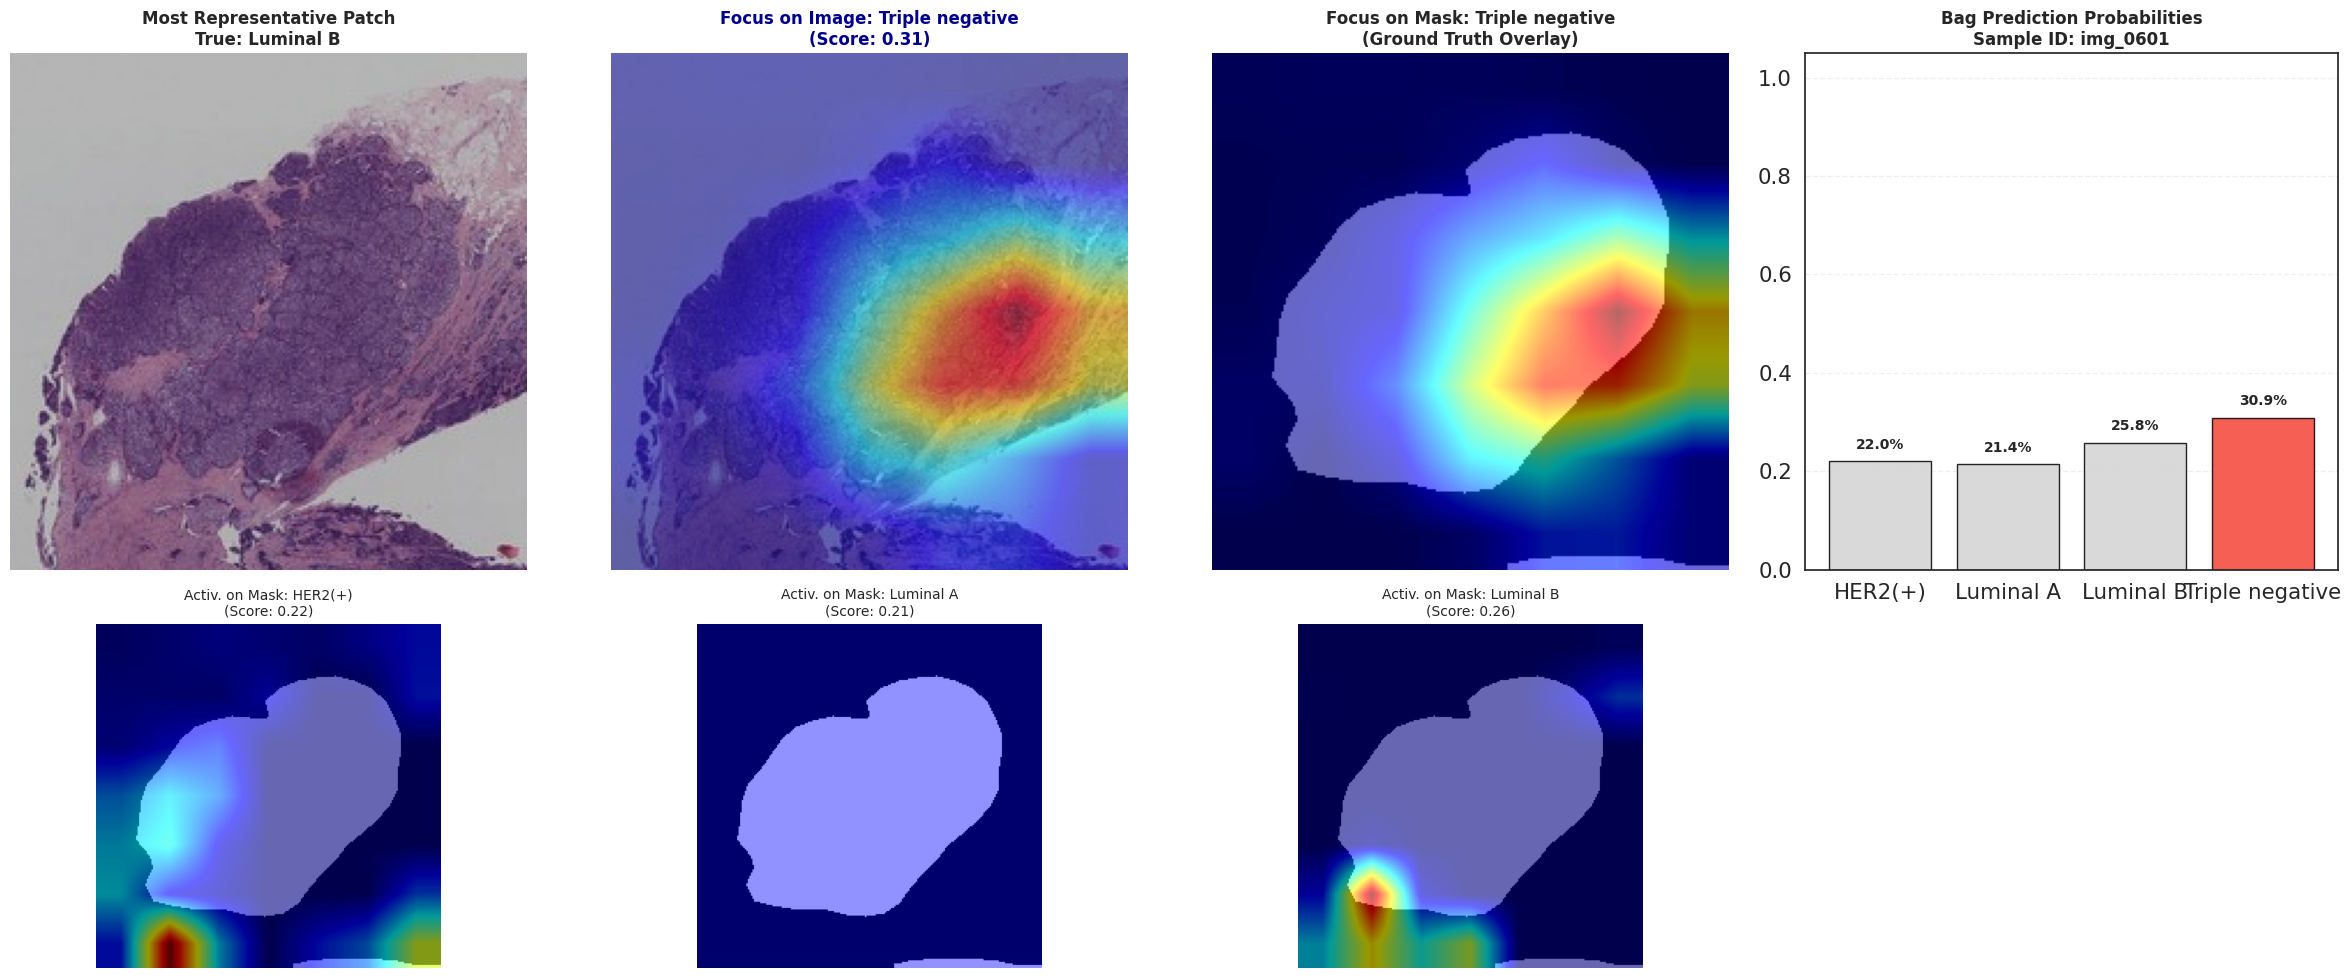

In [ ]:
# Select a sample ID from your validation set
if SUB_MODEL is None:
    SUB_MODEL = 'models/best_model_resnet18_tl.pt'  # Default to TL model if none specified
PATCH_MASKS_DIR = os.path.join(datasets_path, "preprocessing_results","train_patches","masks")

cam_model = RetCCLResNet50(num_classes,
                           DROPOUT_RATE,
                           ckpt_path=SUB_MODEL,
                           freeze_backbone=True).to(device)
cam_model.load_state_dict(torch.load(SUB_MODEL), strict=True)
cam_idx = random.randint(0, len(df_val['sample_id'].unique()) - 1)
sample_id_to_test = df_val['sample_id'].iloc[cam_idx]

visualize_sample_analysis(cam_model, patches_metadata_df, sample_id_to_test, label_encoder, device)
visualize_sample_analysis(cam_model, patches_metadata_df, sample_id_to_test, label_encoder, device, masks_dir=PATCH_MASKS_DIR)

## **14. Submission Creation**

### 14.1 Create Submission Model

In [ ]:
# --- REPLACEMENT FOR SECTION 14.1 ---
SUB_MODEL_PATH = 'models/best_model_optimized.pt'

# We must initialize the model with the SAME dropout/structure as the best config
# If you lost the config variable (e.g. restarted runtime), manually look at the print output from Step 4
# and hardcode the dropout_rate. Otherwise:
sub_model = RetCCLResNet50(
    num_classes=len(label_encoder.classes_),
    dropout_rate=best_config['dropout_rate'], # Uses the variable from Step 5
    freeze_backbone=True,
    ckpt_path="models/best_ckpt.pth", # Dummy path, we overwrite weights next
    unfreeze_last_block=False
)

sub_model.load_state_dict(torch.load(SUB_MODEL_PATH), strict=True)
sub_model.to(device)
print(f"Optimized Submodel loaded from {SUB_MODEL_PATH}")

Submodel models/best_model_RetCCLResNet50_ft.pt loaded for inference.


### 14.2 Define Transform

In [ ]:
val_transform = transforms.Compose([
    # No augmentation for validation, just resizing and normalization
    transforms.Resize(TARGET_SIZE),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

### 14.3 Function: Submission CSV

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch.nn.functional as F
import numpy as np

def generate_submission(model, submission_folder, method='max_confidence', output_csv="submission.csv"):
    """
    Generates a submission file by predicting on patches and aggregating results.

    Args:
        model: Trained PyTorch model.
        submission_folder: Path to folder containing test patches.
        method: 'majority_voting' or 'max_confidence'.
        output_csv: Filename for the output CSV.
    """
    model.eval()

    # 1. Get list of test patches
    patch_files = sorted([f for f in os.listdir(submission_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    print(f"Found {len(patch_files)} patches in {submission_folder}")
    print(f"Aggregation Method: {method}")

    # Store predictions per image
    # Structure: { 'img_0001': {'votes': [], 'probs': []}, ... }
    image_predictions = {}

    print("Running inference...")
    with torch.no_grad():
        for filename in tqdm(patch_files):
            filepath = os.path.join(submission_folder, filename)

            try:
                # Extract Sample ID (e.g., "img_0015_p12.png" -> "img_0015")
                # Adjust split logic if your naming convention is different
                sample_id = filename.rsplit('_p', 1)[0]

                # Initialize dictionary for this sample if new
                if sample_id not in image_predictions:
                    image_predictions[sample_id] = {'probs': []}

                # Load and Transform
                image = Image.open(filepath).convert('RGB')
                input_tensor = val_transform(image).unsqueeze(0).to(device)

                # Predict
                outputs = model(input_tensor)
                probs = torch.softmax(outputs, dim=1)

                # Store probabilities for this patch
                image_predictions[sample_id]['probs'].append(probs.cpu().numpy()[0])

            except Exception as e:
                print(f"Error processing {filename}: {e}")

    # 3. Aggregate Results
    final_results = []

    print(f"Aggregating results for {len(image_predictions)} unique samples...")

    for sample_id, data in image_predictions.items():
        all_probs = np.array(data['probs']) # Shape: [Num_Patches, Num_Classes]

        # Ensure sample_index has .png extension as requested
        sample_index_name = f"{sample_id}.png"

        if len(all_probs) == 0:
            final_results.append({'sample_index': sample_index_name, 'label': "Luminal A"}) # Default fallback
            continue

        if method == 'majority_voting':
            # Get class prediction for each patch
            patch_preds = np.argmax(all_probs, axis=1)
            # Find most frequent class
            counts = np.bincount(patch_preds)
            final_class_idx = np.argmax(counts)

        elif method == 'max_confidence':
            # Option A: Average probabilities (Soft Voting) - usually best/safest
            avg_probs = np.mean(all_probs, axis=0)
            final_class_idx = np.argmax(avg_probs)

            # Option B: Strict Max Confidence (Uncomment if you prefer this)
            # max_probs = np.max(all_probs, axis=0)
            # final_class_idx = np.argmax(max_probs)

        # Decode Label
        pred_label = label_encoder.inverse_transform([final_class_idx])[0]
        final_results.append({'sample_index': sample_index_name, 'label': pred_label})

    # 4. Create Pandas DataFrame and Save
    df_submission = pd.DataFrame(final_results)

    # Ensure correct column order
    df_submission = df_submission[['sample_index', 'label']]

    # Sort by sample_index for neatness
    df_submission.sort_values('sample_index', inplace=True)

    # Save to CSV
    df_submission.to_csv(output_csv, index=False)

    print(f"Submission saved to {output_csv}")
    print(df_submission.head())

    return df_submission



### 14.3 Create the Submission CSV

In [ ]:
# Example Usage:
# Replace 'path/to/SUBMISSION_PATCHES' with the actual path
# If your folder is just named SUBMISSION_PATCHES in current dir:


now = datetime.now()
date_time_str = now.strftime("%d_%b-%H_%M")

sub_dir = os.path.join(os.path.pardir, "submission_csvs")
OUTPUT_NAME = os.path.join(sub_dir, f"submission_ft--{date_time_str}.csv")


os.makedirs(sub_dir, exist_ok=True)

# Check if folder exists
if os.path.exists(SUBMISSION_PATCHES_OUT):
    # Method 1: Max Confidence / Average Probability (Recommended)
    df_sub_max_conf = generate_submission(sub_model, SUBMISSION_PATCHES_OUT, method='max_confidence', output_csv=OUTPUT_NAME)
    print(f"Submission CSV saved to: {OUTPUT_NAME}")

    # Method 2: Majority Voting (Optional, uncomment to run)
    # df_sub_majority_voting = generate_submission(sub_model, SUBMISSION_PATCHES_OUT, method='majority_voting', output_csv="submission_voting.csv")
else:
    print(f"Directory '{SUBMISSION_PATCHES_OUT}' not found. Please create it or set the correct path.")

Found 2301 patches in ../an2dl2526c2/preprocessing_results/submission_patches
Aggregation Method: max_confidence
Running inference...


100%|██████████| 2301/2301 [02:04<00:00, 18.54it/s]


Aggregating results for 477 unique samples...
Submission saved to ../submission_csvs/submission_ft--12_Dec-18_57.csv
   sample_index      label
0  img_0000.png  Luminal B
1  img_0001.png  Luminal A
2  img_0002.png  Luminal B
3  img_0003.png  Luminal B
4  img_0004.png  Luminal A
Submission CSV saved to: ../submission_csvs/submission_ft--12_Dec-18_57.csv
